## Libraries importeren

In [1]:
import os
import requests
import tarfile
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random
import cv2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

#### Set seed

In [2]:
torch.manual_seed(42)
np.random.seed(42)

## Train en test data samenstellen

#### Functies maken voor downloaden, extraheren en samenstellen

In [12]:
def downloaden_en_extraheren(url, path):
    ## Downloaden
    os.makedirs(path, exist_ok=True)
    filename = os.path.join(path, url.split('/')[-1])
    folder_name = os.path.join(path, url.split('/')[-1].split('.')[0])
    
    if not os.path.exists(folder_name):
        print(f"{filename} downloaden...")
        response = requests.get(url, stream=True)
        totale_grootte = float(response.headers.get('content_length', 0))
        
        with open(filename, 'wb') as file, tqdm(
            desc=filename,
            total=totale_grootte,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
            print("Downloaden voltooid!")
            
            ## Extraheren
        if filename.endswith('.tar.gz') or filename.endswith('.tgz'):
          print(f"{filename} extraheren...")
          with tarfile.open(filename, 'r:gz') as tar:
              tar.extractall(path=path)
              print("Extraheren voltooid! Bbox en labels koppelen...")
              
        os.remove(filename)
class SVHNDataset(Dataset):
    def __init__(self, root_dir, url, transform=None):
        self.root_dir = root_dir
        self.url = url
        self.transform = transform
        
        downloaden_en_extraheren(url, root_dir)
        
        folder_name = url.split('/')[-1].split('.')[0]
        self.image_dir = os.path.join(root_dir, folder_name)
        self.mat_path = os.path.join(self.image_dir, 'digitStruct.mat')
        
        self.mat = h5py.File(self.mat_path, 'r')
        self.name_refs = self.mat['digitStruct']['name']
        self.bbox_refs = self.mat['digitStruct']['bbox']
        self.length = self.name_refs.shape[0]
    
    def __len__(self):
        return self.length
    
    def _get_name(self, index):
        name_ref = self.name_refs[index][0]
        name = ''.join([chr(self.mat[name_ref][j][0]) for j in range(self.mat[name_ref].shape[0])])
        return name
    
    def _get_bbox(self, index):
        bbox_ref = self.bbox_refs[index[0]]
        bbox = {}
        for key in ['height', 'left', 'top', 'width', 'label']:
            attr = self.mat[bbox_ref[key]]
        
            if len(attr) > 1:
                ## Geen idee wat dit doet
                bbox[key] = [self.mat[attr[j][0]][()][0][0] for j in range(len(attr))]
            else:
                bbox[key] = [self.mat[attr][()][0][0]]
        return bbox
    
    def __getitem__(self, index):
        img_name = self._get_name(index)
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        bbox = self._get_bbox(index)
        labels = np.array(bbox['label'])
        lefts = np.array(bbox['left'])
        tops = np.array(bbox['top'])
        widths = np.array(bbox['width'])
        heights = np.array(bbox['height'])
        
        x_min = np.min(lefts)
        y_min = np.min(tops)
        x_max = np.max(lefts + widths)
        y_max = np.max(tops + heights)
        combineerde_bbox = np.array([x_min, y_min, x_max, y_max], dtype=np.float32)
        
        if self.transform:
            image = self.transform(image)
            
        main_label = int(labels[0])
        
        return image, torch.tensor(main_label), torch.tensor(combineerde_bbox)
    
urls = {
    'train': 'http://ufldl.stanford.edu/housenumbers/train.tar.gz',
    'test': 'http://ufldl.stanford.edu/housenumbers/test.tar.gz',
    'extra': 'http://ufldl.stanford.edu/housenumbers/extra.tar.gz'
}

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

#### Dataset inladen en inzien
Voordat ik de data volledig ga transformeren, wil ik eerst het gemiddelde en de standaardafwijking weten voor de normalisatie. Daarnaast wil ik ook weten wat de grote van de afbeelding is qua pixels en het kanaal (grijstinten of rgb).

In [14]:
train_dataset = SVHNDataset(root_dir='./Data/SVHN', url=urls['train'], transform=transform)
test_dataset = SVHNDataset(root_dir='./Data/SVHN', url=urls['test'], transform=transform)

#### Data transformeren

##### Custom functies maken

In [4]:
def random_background(img):
    achtergrond_kleur = random.randint(190, 240)
    afbeelding_np = np.array(img)
    mask = afbeelding_np < 255
    
    achtergrond = np.full_like(afbeelding_np, achtergrond_kleur)
    afbeelding_np = np.where(mask, afbeelding_np, achtergrond)
    return Image.fromarray(afbeelding_np.astype(np.uint8))

def custom_erasing(img, strength):
    afbeelding_np = np.array(img)
    mask = afbeelding_np < 255

    coördinaten = np.argwhere(mask)
    coördinaten_gesorteerd = coördinaten[np.lexsort((coördinaten[:, 1], coördinaten[:, 0]))]

    aantal_te_verwijderen = int(len(coördinaten_gesorteerd) * (strength ** 2))

    if aantal_te_verwijderen == 0:
        return img
    
    if np.random.rand() < 0.5:
        geselecteerde = coördinaten_gesorteerd[:aantal_te_verwijderen]
    else:
        geselecteerde = coördinaten_gesorteerd[-aantal_te_verwijderen:]
        
    for y, x in geselecteerde:
        afbeelding_np[y, x] = 255

    return Image.fromarray(afbeelding_np.astype(np.uint8))


In [5]:
transform = transforms.Compose([
    transforms.Resize((32, 32)), #Juiste afmetingen invoeren 
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])

train_data = datasets.SVHN(root='./data', split='train', download=True, transform=transforms.ToTensor())
test_data = datasets.SVHN(root='./data', split='test', download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


#### Train data inspecteren

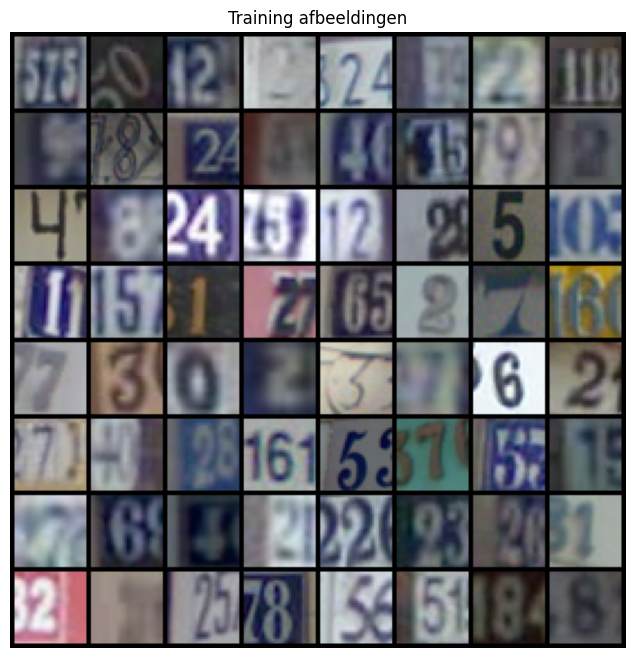

torch.Size([3, 32, 32])


In [7]:
eerste_batch = next(iter(train_loader))
images, labels = eerste_batch

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Training afbeeldingen")

grid_afbeeldingen = np.transpose(vutils.make_grid(images[:100], padding=2, normalize=True), (1, 2, 0))

plt.imshow(grid_afbeeldingen)
plt.show()

#Formaat checken
image, label = test_data[0]
print(image.shape)

## Architectuur van CNN bouwen

In [15]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 10)
        self.fc3 = nn.Linear(256, 4)
    
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.batchnorm1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.batchnorm2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.batchnorm3(self.conv3(x))))
        
        x = nn.Flatten()(x)
        
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
            
        num_output = self.fc2(x)
        bbox_output = self.fc3(x)
        
        return num_output, bbox_output

#### Check voor GPU
I.v.m. dat het model zwaar kan zijn, check ik eerst ff of het huidige apparaat een GPU heeft. Dit kan het trainen een stuk versneller namelijk.

In [16]:
component = torch.device("cuda" if torch.cuda.is_available()
                         else "cpu")
model = CNN_Model()
model = model.to(component)
print(f"Model runt op {component}")

Model runt op cpu


## Model trainen

In [17]:
optimalisator = optim.Adam(model.parameters(), lr=0.001)

num_criterium = nn.CrossEntropyLoss()
bbox_criterium = nn.MSELoss()

In [18]:
epochs = 10
for epoch in range(epochs):
    model.train()
    totale_loss = 0.0
    totale_num_loss = 0.0
    totale_bbox_loss = 0.0
    
    for images, labels, bbox in train_loader:
        optimalisator.zero_grad()

        images, labels, bbox = images.to(component), labels.to(component), bbox.to(component) #Runt het model op het geschikte component
        
        num_output, bbox_output = model(images)
        
        loss_num = num_criterium(num_output, labels)
        loss_bbox = bbox_criterium(bbox_output, bbox)
        
        totale_loss_waarde = loss_num + loss_bbox
        totale_loss_waarde.backward()
        optimalisator.step()
        
        totale_loss += totale_loss_waarde.item() 
        totale_num_loss += loss_num.item()
        totale_bbox_loss = loss_bbox.item()
    
    print(f"Epoch {epoch + 1}, "
          f"Totale loss: {totale_loss / len(train_loader):.2f}",
          f"Nummer loss: {totale_num_loss / len(train_loader):.2f}",
          f"Bbox loss: {totale_bbox_loss / len(train_loader):.2f}")

torch.save(model.state_dict(), "Getrainde_modellen/CNN_Model_gewichten.pth")


ValueError: not enough values to unpack (expected 3, got 2)

#### Laad getrainde model indien nodig (voor apparaten zonder cuda bijvoorbeeld)

In [16]:
model.load_state_dict(torch.load("Getrainde_modellen/CNN_Model_gewichten.pth", 
                                 map_location=torch.device(component)))


<All keys matched successfully>

## Evaluatie van model

In [17]:
model.eval()
with torch.no_grad():
    correct_voorspeld = 0
    totaal_voorspeld = 0
    for images, labels in test_loader:
        images, labels = images.to(component), labels.to(component)
        test_output = model(images)
        _, predicted = torch.max(test_output, 1)
        correct_voorspeld += (predicted == labels).sum().item()
        totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:16].tolist())  
print("Voorspelde labels:", predicted[:16].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")

Werkelijke labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Voorspelde labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Accuratie na training: 98.97%


## Live camera interface